# **Gasoline Pricing, Tax, and Consumptions in the U.S** 
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/1st_Cavalry_Division_Patch.svg/150px-1st_Cavalry_Division_Patch.svg.png" width='300px'> 

In [1]:
# ODIN-Project Dependencies 
from odin_eia_db.engine.odin_spark import ODINSpark
from odin_eia_db.utils.odin_secrets_manager import ODINSecretsManager
from odin_eia_db.gasoline_pricing import ODINGasolinePricing
from odin_eia_db.utils.constants import TBL_NAME, INVERSE_US_REGIONS, PADD_AREAS, US_REGIONS
from eia.utils.constants import INVERSE_STATES
from pyspark.sql import functions as f 
from pyspark.sql.types import DecimalType

from datetime import datetime
import pandas as pd 
import numpy as np 
import pymysql 
import warnings
import json 
import urllib 

import matplotlib.pyplot as plt 
import seaborn as sns 

from typing import List, Dict 

plt.style.use('ggplot') 
warnings.filterwarnings('ignore') 

## **Helper Functions** 

In [6]:
@f.udf 
def mapped_padd_district(state_name: str) -> str: 
    """
    FUNCTION 
        mapped_padd_district

    DESCRIPTION 
        ODIN-Spark helper function to mapped a given state_name into its PADD district

    RETURN 
        A string object (PADD District (e.q., PADD 1, PADD 2, etc.)
    """ 
    return PADD_AREAS.get( INVERSE_US_REGIONS.get( INVERSE_STATES.get(state_name) ), 'N/A' )

@f.udf
def get_month_name(transc_date: str): 
    """
    FUNCTION 
        get_month_name

    DESCRIPTION 
        ODIN-Spark helper function to convert timestamp into transc_date format %Y-%m-%d 

    RETURN 
        A pandas.datetime object 
    """
    return pd.to_datetime(transc_date if transc_date else datetime.today().strftime('%Y-%m-%d') ).month_name()

@f.udf
def convert_gasoline_price_to_decimal(price: float): 
    """
    FUNCTION 
        convert_gasoline_price_to_decimal

    DESCRIPTION 
        ODIN-Spark helper function to current_gasoline_price into its decimal representation 

    RETURN 
        A string object 
    """
    try: 
        return str(float(price))

    except: 
        return "0.0"


def get_gasoline_prices_by_products(url: str) -> 'DataFrame':
    """
    FUNCTION 
        get_gasoline_prices_by_products

    DESCRIPTION 
        Get current gasoline pricing by their products from EIA.gov 

    PARAMETER 
        None 

    RETURN 
        DataFrame with the following attributes: period, duoarea, area-name, product, product-name, process, process-name, series, series-description, value, units

    EXAMPLES 
    >>> gasoline_price_by_prodcuts: 'DataFrame' = get_gasoline_prices_by_products()
    >>> period	duoarea	area-name	product	product-name	process	process-name	series	series-description	value	units
    0	2022-02	NUS	U.S.	EPMR	Regular Gasoline	PTA	Retail Sales by All Sellers	EMA_EPMR_PTA_NUS_DPG	U.S. Regular Gasoline Retail Sales by All Sell...	None	$/GAL
    """ 

    if not url: 
        return ValueError("[ ERROR ] Please provide the a valid EIA url!!!")
        
    headers: Dict = {'accept': "application/json, text/plain, */*", 
                     'user-agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:46.0) Gecko/20120121 Firefox/46.0'}
    try: 
        return pd.DataFrame( json.loads( urllib.request.urlopen(urllib.request.Request(url=url, headers=headers) ).read().decode('utf-8') ).get('response').get('data') )

    except ConnectionError as e: 
        
        raise ConnectionError(f"[ ERROR ] Unable to fetch the data. Please try again or check your API key!!!")

## **ODIN-Resources**

In [3]:
odin_secrets: ODINSecretsManager = ODINSecretsManager()
user,passwd,host,db, _ = list(odin_secrets.get_secrets(secret_name='mysql_develoment').values())
con: 'ODIN-MySQL' = pymysql.connect(user=user, passwd=passwd, host=host, db=db)
odin_eia: ODINGasolinePricing = ODINGasolinePricing()  

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


## **Gasoline & Diesel for transportation by US state in (US cents/gallon) as of October 2021** 

In [51]:
tax_df: 'DataFrame' = pd.io.html.read_html("https://en.wikipedia.org/wiki/Fuel_taxes_in_the_United_States")[0] 
tax_df['Gasoline tax (¢/gal) (excludes federal tax of 18.4¢/gal)'] = tax_df['Gasoline tax (¢/gal) (excludes federal tax of 18.4¢/gal)'].astype(str).apply(lambda row: row.replace("[9]", "")).astype(float)
tax_df['Notes'] = tax_df['Notes'].replace({np.nan: "N/A"})
tax_df = tax_df.rename({tax_df.columns.tolist()[1]: 'Gasoline tax (¢/gal)'}, axis=1)
tax_df['federal tax of 18.4¢/gal']= [18.4] *tax_df.shape[0]
tax_df['PADD_Distric'] = tax_df['State'].apply(lambda row: PADD_AREAS.get( INVERSE_US_REGIONS.get(row) , 'N/A' ) )
padd_district, avg_state_tax = zip(*tax_df.query("PADD_Distric != 'N/A' ").groupby('PADD_Distric')['Gasoline tax (¢/gal)'].mean().apply(lambda row: round(row, 2) ).to_dict().items() )

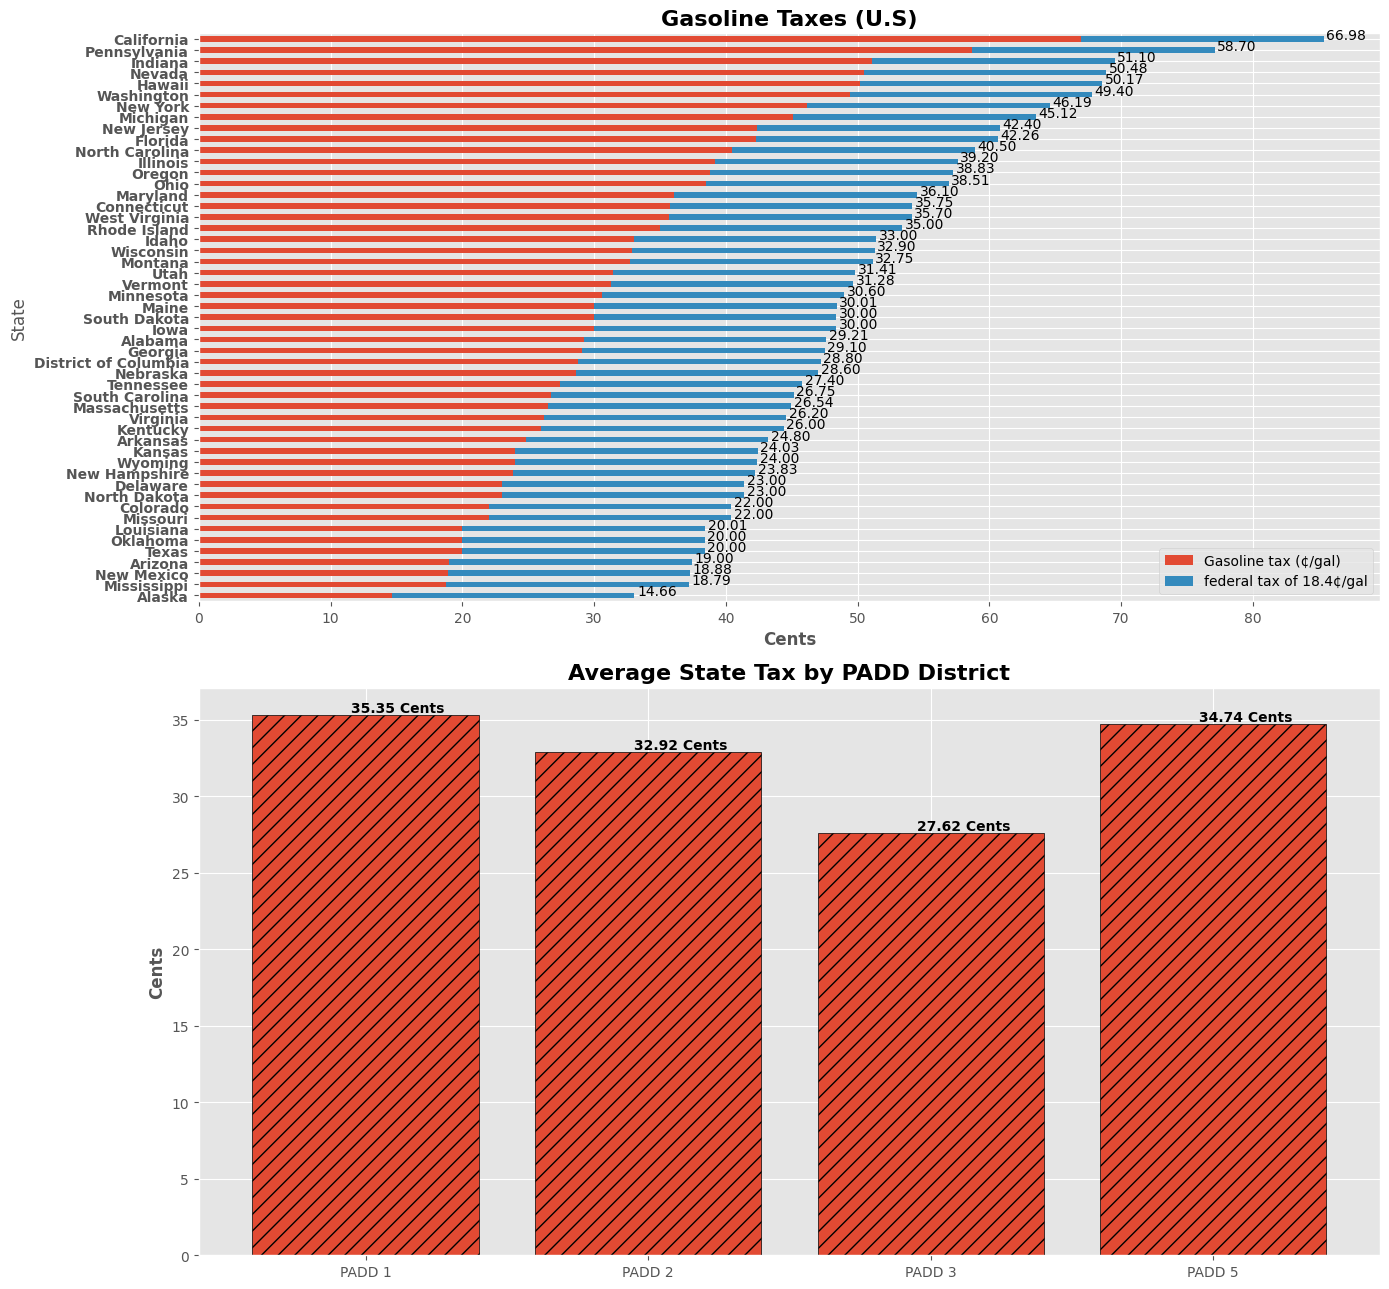

In [79]:
fig = plt.figure(figsize=(14,13))
ax = fig.add_subplot(2,1,1) 
tax_df[tax_df.columns.tolist()[:2] + [ tax_df.columns[-2] ] ].sort_values(by=tax_df.columns.tolist()[1], ascending=True).set_index('State').plot(kind='barh', stacked=True, ax=ax)
ax.set_title("Gasoline Taxes (U.S)", fontweight='bold', fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold') 
ax.set_xlabel("Cents", fontweight='bold')

states, taxes = zip(*tax_df[tax_df.columns.tolist()[:2] + [ tax_df.columns[-2] ] ].sort_values(by=tax_df.columns.tolist()[1], ascending=True).set_index('State').apply(lambda row: row[tax_df.columns.tolist()[1]] + row[tax_df.columns.tolist()[-2]] , axis=1).to_dict().items())
for index,tax in enumerate(taxes): 
    ax.annotate(text=f"{tax-18.4:.2f}", xy=(tax + 0.2,index))

ax = fig.add_subplot(2,1,2)
ax.bar(x=list(padd_district), height=list(avg_state_tax), hatch='//', ec='k')
ax.set_title("Average State Tax by PADD District", fontweight='bold', fontsize=16)
ax.set_ylabel("Cents", fontweight='bold')

for index,state_tax in enumerate(avg_state_tax):
    ax.annotate(text=f"{state_tax:.2f} Cents", xy=(index - 0.05, state_tax + 0.184), fontweight='bold')

plt.tight_layout() 

## **ODIN-Legacy Pricing** 

In [8]:
query: str = """
SELECT 
    l.gas_station AS `gas_station_name`, 
    l.price, 
    l.timestamp AS `postedtime`, 
    l.state, 
    l.latitude, 
    l.longitude, 
    CONCAT( l.address, ', ', l.city, ', ',  l.state, ', ', l.zip_code  ) AS `store_address`
FROM legacy_gasoline_pricing l 
"""
legacy_pricing: ODINSpark = ODINSpark(app_name='ODIN Legacy Pricing').exec_odin_mysql_query(query=query)
legacy_pricing.show(5) 


DEBUG:odin_eia_db.engine.odin_spark:
        
                  ..`                                 ./sdmds:`                                             
                +dmmds+-`                          -+ymmmmmmmmdo:`                            ./osyyy/`     
              `ommmmmmmmdhso:`                 ./shmmmmmmmmmmmmmmds/.                     ./ohmmmdmdmm/     
              +mmmmmmmmmmmmmmmhy+//:://///++shdmmmmmmmmmmhsdmmmmmmmmmddyso+/::--.-://+syhdmmmmmmmmmmmmh`    
             :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm+    
            .hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmsooodmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmd.   
            ommmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmh+osoymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm/   
           :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooo+oohmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmms   
          `hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdsoo+ososmmmmmmmmmmmmmmmmmmmm

:: loading settings :: url = jar:file:/opt/spark-3.5.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fa459c78-cfd4-4d53-8728-5cb6c8ddfdf1;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 458ms :: artifacts dl 24ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.901 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.1 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evi

+--------------------+-----+----------+-----+---------------+----------------+--------------------+
|    gas_station_name|price|postedtime|state|       latitude|       longitude|       store_address|
+--------------------+-----+----------+-----+---------------+----------------+--------------------+
|               Shell|  0.0|      NULL|   PR|      18.469372|      -67.152922|FR9W+QRV, Ave Dr ...|
|Torrecilla Servic...|  0.0|      NULL|   PR|     18.1892275|     -66.3475681|PR-156, Barranqui...|
|              Texaco|  0.0|      NULL|   PR|      18.384787|      -66.144218|Ave. Aguas Buenas...|
|               Shell|  0.0|      NULL|   FL|28.308393432147| -81.42654620111|2201 W Columbia A...|
|            Marathon|  0.0|      NULL|   FL|26.286835556923|-80.110695362091|4517 N Dixie Hwy,...|
+--------------------+-----+----------+-----+---------------+----------------+--------------------+
only showing top 5 rows



## **Current Gasoline Pricing** 

In [9]:
query: str = """ 
SELECT 
    g.gas_station_name, 
    g.price, 
    g.postedtime, 
    g.state, 
    g.latitude, 
    g.longitude, 
    CONCAT( g.address, ', ', g.city, ', ',  g.state, ', ', g.zip_code  ) AS `store_address`
FROM gasoline_pricing g 
"""
gasoline_pricing: ODINSpark = ODINSpark(app_name="Current Gasoline Pricing").exec_odin_mysql_query(query=query)

# Merged Legacy & Current Pricing Together  
merged_pricing: 'DataFrame' = gasoline_pricing.union(legacy_pricing) 
merged_pricing = merged_pricing.dropna(subset=['gas_station_name', 'latitude', 'longitude' ] )  
merged_pricing = merged_pricing.dropna(subset='postedtime')  
merged_pricing = merged_pricing.withColumn('price', convert_gasoline_price_to_decimal('price').cast('double').alias('price') )
merged_pricing = merged_pricing.withColumn('transc_date', f.date_format('postedtime', 'yyyy-MM-dd').alias('transc_date') )
merged_pricing = merged_pricing.withColumn('padd_district', mapped_padd_district('state').alias('padd_district') )
merged_pricing = merged_pricing.withColumn('state', f.trim( f.when( f.length( f.trim('state').alias('state')) == 2, f.col('state')).otherwise("Invalid").alias('state')).alias('state')  )

merged_pricing.show(5)

DEBUG:odin_eia_db.engine.odin_spark:
        
                  ..`                                 ./sdmds:`                                             
                +dmmds+-`                          -+ymmmmmmmmdo:`                            ./osyyy/`     
              `ommmmmmmmdhso:`                 ./shmmmmmmmmmmmmmmds/.                     ./ohmmmdmdmm/     
              +mmmmmmmmmmmmmmmhy+//:://///++shdmmmmmmmmmmhsdmmmmmmmmmddyso+/::--.-://+syhdmmmmmmmmmmmmh`    
             :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm+    
            .hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmsooodmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmd.   
            ommmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmh+osoymmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm/   
           :dmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdooo+oohmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmms   
          `hdmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmdsoo+ososmmmmmmmmmmmmmmmmmmmm

+------------------+-----+--------------------+-----+---------------+----------------+--------------------+-----------+-------------+
|  gas_station_name|price|          postedtime|state|       latitude|       longitude|       store_address|transc_date|padd_district|
+------------------+-----+--------------------+-----+---------------+----------------+--------------------+-----------+-------------+
|           Chevron| 4.19|2024-05-04T18:40:...|   AZ|      33.538166|     -112.168975|5105 W Glendale A...| 2024-05-04|       PADD 5|
|        Broad Mart| 3.22|2024-05-05T08:32:...|   IN|39.930970847202|-85.363324284554|1709 E Broad St, ...| 2024-05-05|       PADD 2|
|            Valero| 3.37|2024-05-05T12:27:...|   DE|39.175316057398|-75.524193048477|530 N Dupont Hwy,...| 2024-05-05|       PADD 1|
|       Racing Mart| 3.29|2024-05-05T15:15:...|   MA|      42.135595|      -72.568991|1037 St James Ave...| 2024-05-05|       PADD 1|
|Wintun Mini Market| 4.32|2024-05-05T15:25:...|   CA|       39

In [6]:
merged_pricing.printSchema() 

root
 |-- gas_station_name: string (nullable = true)
 |-- price: double (nullable = true)
 |-- postedtime: string (nullable = true)
 |-- state: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- store_address: string (nullable = true)
 |-- transc_date: string (nullable = true)



## **Avg Gasoline Pricing (`EIA`)**

In [7]:
ca_df: 'CaliforniaPricing' = merged_pricing.filter(f.col('state') == 'CA' ).withColumn('before_tax',  f.round( (f.col('price') - (0.6698 + 0.184 )).alias('before_tax'), 2)  )
ca_df = ca_df.withColumn('transc_date', f.date_format('postedtime', 'yyyy-MM-dd' ) ) 
ca_df = ca_df.withColumn('month_name', get_month_name(f.col('transc_date')) )
ca_df = ca_df.dropna(subset='transc_date')

daily_pricing: List[Dict] = [ item.asDict() for item in ca_df.select('postedtime', 'price', 'before_tax' ).collect() ] 
daily_pricing_df: 'DataFrame' = pd.DataFrame( daily_pricing)
daily_pricing_df = daily_pricing_df.astype(str).query(f"postedtime != 'None' ")
daily_pricing_df['postedtime'] = pd.to_datetime(daily_pricing_df['postedtime'] )
daily_pricing_df['price'] = daily_pricing_df['price'].astype(float) 
daily_pricing_df['before_tax'] = daily_pricing_df['before_tax'].astype(float) 

premium_gasoline_ca: 'DataFrame' = odin_eia.get_conventional_premium_gasoline(state_name='california')
premium_gasoline_ca['period'] = pd.to_datetime(premium_gasoline_ca['period'] ) 
premium_gasoline_ca = premium_gasoline_ca.rename({'value': 'avg_price'}, axis=1)

ca_df.show(5) 

+------------------+-----+--------------------+-----+---------------+-----------------+--------------------+-----------+----------+----------+
|  gas_station_name|price|          postedtime|state|       latitude|        longitude|       store_address|transc_date|before_tax|month_name|
+------------------+-----+--------------------+-----+---------------+-----------------+--------------------+-----------+----------+----------+
|Wintun Mini Market| 4.32|2024-05-05T15:25:...|   CA|       39.25746|       -122.03053|3790 State Hwy 45...| 2024-05-05|      3.47|       May|
|          Sinclair| 4.49|2024-05-06T11:55:...|   CA|      33.870384|      -117.943363|1101 W Commonweal...| 2024-05-06|      3.64|       May|
|          Sinclair| 4.59|2024-05-06T13:07:...|   CA|      33.870384|      -117.943363|1101 W Commonweal...| 2024-05-06|      3.74|       May|
|            Costco| 4.39|2024-05-06T14:26:...|   CA|33.802444959425|-116.388974413276|72800 Dinah Shore...| 2024-05-06|      3.54|       May|

## **Distribution of Daily Gasoline Pricing and Average Premium Gasoline Pricing in `California`** 
- Highest State + Federal Tax

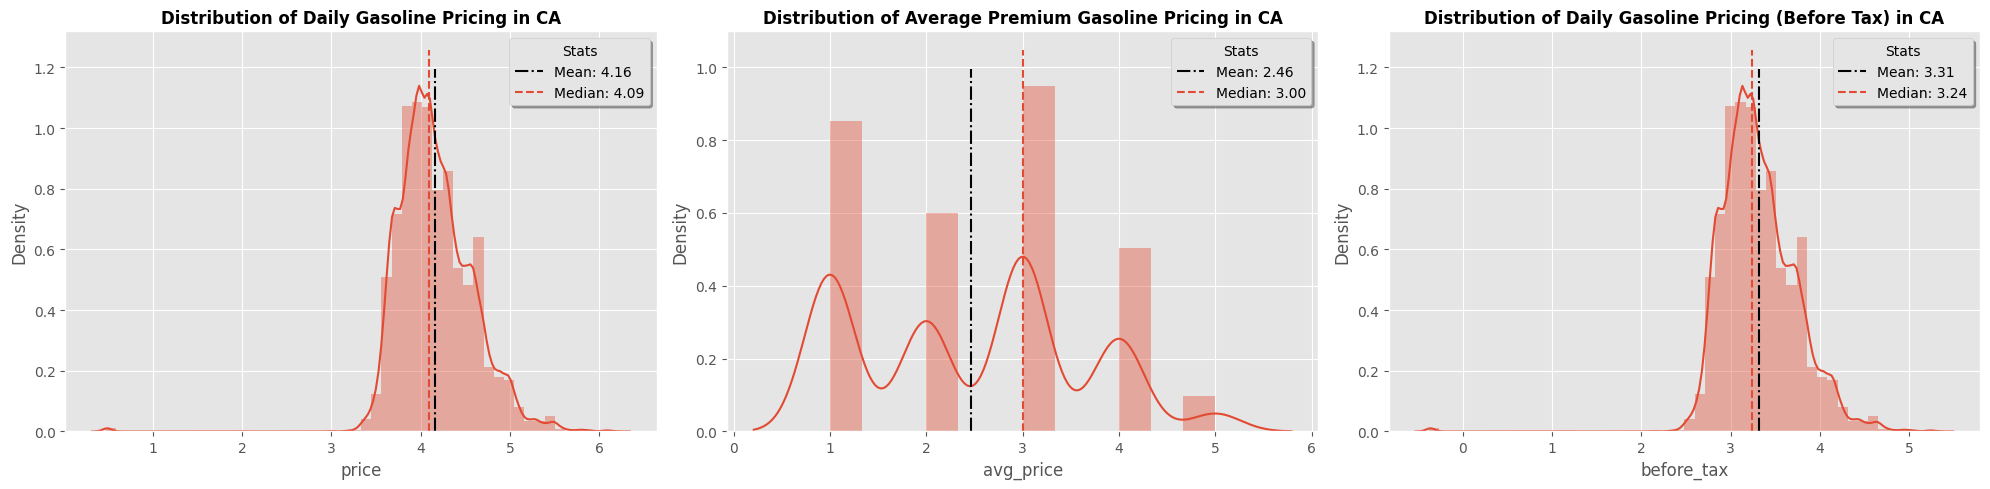

In [16]:
fig = plt.figure(figsize=(20,5))

# Daily Gasoline Pricing 
ax = fig.add_subplot(1,3,1)

mean: float = daily_pricing_df['price'].mean() 
median: float = daily_pricing_df['price'].median() 

sns.distplot( daily_pricing_df['price'],ax=ax )
ax.set_title("Distribution of Daily Gasoline Pricing in CA", fontweight='bold', fontsize=12)
ax.vlines(x=mean, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Mean: {mean:.2f}", linestyles='-.', color='black')
ax.vlines(x=median, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Median: {median:.2f}", linestyles='--')
ax.legend(title="Stats", fancybox=True, shadow=True)

# Average Premium Gasoline Pricing 
ax = fig.add_subplot(1,3,2)
mean: float = premium_gasoline_ca['avg_price'].mean() 
median: float = premium_gasoline_ca['avg_price'].median() 

sns.distplot( premium_gasoline_ca['avg_price'],ax=ax )
ax.set_title("Distribution of Average Premium Gasoline Pricing in CA", fontweight='bold', fontsize=12)
ax.vlines(x=mean, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Mean: {mean:.2f}", linestyles='-.', color='black')
ax.vlines(x=median, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Median: {median:.2f}", linestyles='--')
ax.legend(title="Stats", fancybox=True, shadow=True)

# Before Tax Pricing (Daily) 
ax = fig.add_subplot(1,3,3)
mean: float = daily_pricing_df['before_tax'].mean() 
median: float = daily_pricing_df['before_tax'].median() 

sns.distplot( daily_pricing_df['before_tax'],ax=ax )
ax.set_title("Distribution of Daily Gasoline Pricing (Before Tax) in CA", fontweight='bold', fontsize=12)
ax.vlines(x=mean, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Mean: {mean:.2f}", linestyles='-.', color='black')
ax.vlines(x=median, ymin=0.0, ymax=ax.get_ylim()[1], label=f"Median: {median:.2f}", linestyles='--')
ax.legend(title="Stats", fancybox=True, shadow=True)


plt.tight_layout() 

## **Avg Daily/Weekly Regular & Premium Gasoline Price Trends (Duration: May - June 2024)** 

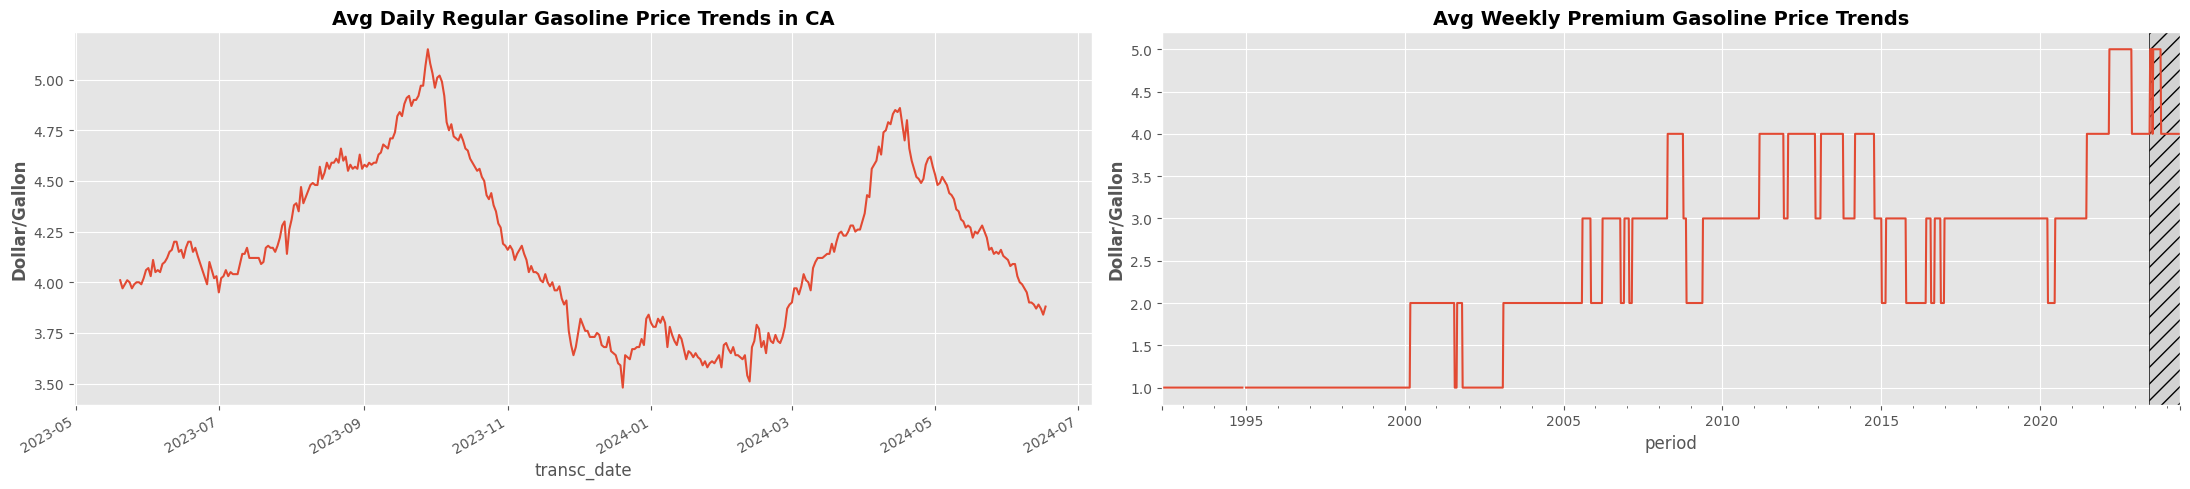

In [18]:
avg_gasoline_price: 'DataFrame' = pd.DataFrame([ item.asDict() for item in ca_df.groupBy('transc_date').agg(f.round(f.avg('price'), 2).alias('avg_price') ).collect() ]) 
avg_gasoline_price['transc_date'] = pd.to_datetime(avg_gasoline_price['transc_date'] )

fig = plt.figure(figsize=(22,5))
ax = fig.add_subplot(1,2,1)
avg_gasoline_price.set_index('transc_date')['avg_price'].plot(ax=ax)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_title("Avg Daily Regular Gasoline Price Trends in CA", fontweight='bold', fontsize=14)

ax = fig.add_subplot(1,2,2)
premium_gasoline_ca.set_index('period')['avg_price'].sort_index().plot(ax=ax) 
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_title("Avg Weekly Premium Gasoline Price Trends", fontweight='bold', fontsize=14)
ax.axvspan(xmin=2789 , xmax=2840, ec='k', fc='lightgray', hatch='//')

plt.tight_layout() 

## **Average Gasoline Price by State**

In [97]:
avg_gasoline_prices_by_state: 'DataFrame' = pd.DataFrame( [ item.asDict() for item in  merged_pricing.filter("state != 'Invalid' ").groupBy('state').agg(f.round( f.avg('price'),2 ).alias('avg_price') ).orderBy('avg_price').collect() ] )
states,avg_prices = zip(*avg_gasoline_prices_by_state.set_index('state').to_dict().get('avg_price').items()  )

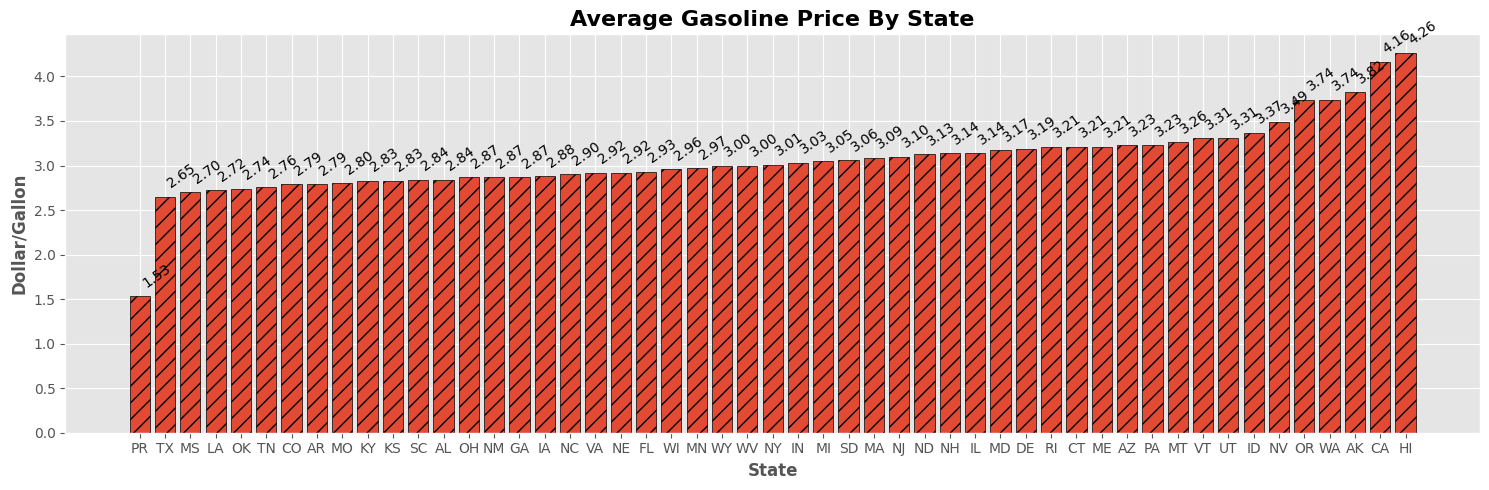

In [110]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot() 

ax.bar(x=list(states), height=list(avg_prices), ec='k', hatch='//')
ax.set_title("Average Gasoline Price By State", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_xlabel("State", fontweight='bold')

for index,price in enumerate(avg_prices):
    ax.annotate(text=f"{price:.2f}", xy=(index,price + 0.1), rotation=35)
plt.tight_layout() 

## **Average Gasoline Price by PADD District** 

In [69]:
merged_pricing.filter( "padd_district != 'N/A' ").filter("padd_district != 'Not Applicable' " ).groupBy('padd_district').agg(f.round( f.avg('price'),2).alias('avg_price') ).orderBy('avg_price').show() 

+-------------+---------+
|padd_district|avg_price|
+-------------+---------+
|       PADD 3|     2.82|
|       PADD 2|     2.97|
|       PADD 1|     3.17|
|       PADD 5|     3.42|
+-------------+---------+



## **Gasoline Prices by Formulation, Grade, Sales Type (`EIA`)** 

In [16]:
odin_secrets.get_secrets(secret_name='afghan_project').get('eia_url')

'https://api.eia.gov/v2/petroleum/pri/allmg/data/?api_key=3zjKYxV86AqtJWSRoAECir1wQFscVu6lxXnRVKG8&frequency=monthly&data[0]=value&facets[series][]=EMA_EPMR_PTA_NUS_DPG&start=1983-01&end=2022-03&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'

In [17]:
gasoline_price_by_prodcuts: 'DataFrame' = get_gasoline_prices_by_products(url=odin_secrets.get_secrets(secret_name='afghan_project').get('eia_url'))
gasoline_price_by_prodcuts['period'] = gasoline_price_by_prodcuts['period'].apply(lambda row: pd.to_datetime( "%s-01" % (row) ) )
gasoline_price_by_prodcuts['value'] = gasoline_price_by_prodcuts['value'].astype(float) 
gasoline_price_by_prodcuts.head(10)

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2022-02-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
1,2022-01-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
2,2021-12-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
3,2021-11-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
4,2021-10-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
5,2021-09-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
6,2021-08-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
7,2021-07-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
8,2021-06-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL
9,2021-05-01,NUS,U.S.,EPMR,Regular Gasoline,PTA,Retail Sales by All Sellers,EMA_EPMR_PTA_NUS_DPG,U.S. Regular Gasoline Retail Sales by All Sell...,NaN,$/GAL


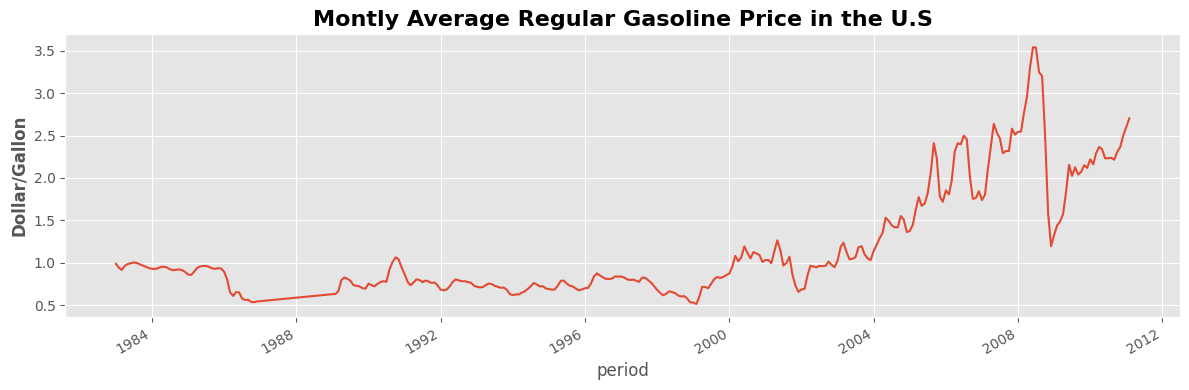

In [23]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot() 

gasoline_price_by_prodcuts[~gasoline_price_by_prodcuts['value'].isna()].set_index('period')['value'].replace({np.nan:0.0}).sort_index().plot(ax=ax)
ax.set_title("Montly Average Regular Gasoline Price in the U.S", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
plt.tight_layout() 

## **Gasoline Prices Comparison (`CA, PA, HI, WA, TX`)** 
- `Figure 1.2` shows that PADD 5 has the highest gasoline avg_price due to higher tax (both state & federal) 

In [11]:
comp_prices: 'DataFrame' = merged_pricing.filter("state == 'WA' ").dropna(subset='postedtime').union(merged_pricing.filter("state == 'HI' ").dropna(subset='postedtime')).union(merged_pricing.filter("state == 'CA' ").dropna(subset='postedtime')).union(merged_pricing.filter("state == 'PA' ").dropna(subset='postedtime')) 
pricing_comp_df: 'DataFrame' = pd.DataFrame([ item.asDict() for item in comp_prices.select('postedtime', 'padd_district', 'state', 'price' ).collect() ] )
pricing_comp_df['state_name'] = pricing_comp_df['state'].apply(lambda row: INVERSE_STATES.get(row))

# Prices by PADD Districts
padd_prices: 'DataFrame' = pd.DataFrame( [ item.asDict() for item in merged_pricing.filter("padd_district != 'N/A' ").filter("padd_district != 'Not Applicable' ").select('postedtime', 'padd_district', 'state', 'price' ).collect() ] )
padd_prices = padd_prices.astype(str).query("postedtime != 'None' ")
padd_prices['postedtime'] = pd.to_datetime( padd_prices['postedtime'] )
padd_prices['transc_date'] = pd.to_datetime(  padd_prices['postedtime'].apply(lambda row: row.strftime('%Y-%m-%d')  ) )
padd_prices['price'] = padd_prices['price'].astype(float)

comp_prices.show()

+--------------------+-----+--------------------+-----+---------------+-----------------+--------------------+-----------+-------------+
|    gas_station_name|price|          postedtime|state|       latitude|        longitude|       store_address|transc_date|padd_district|
+--------------------+-----+--------------------+-----+---------------+-----------------+--------------------+-----------+-------------+
|Swinomish Markets...| 3.99|2024-05-05T15:26:...|   WA|       48.45662|       -122.51837|12939 Casino Dr, ...| 2024-05-05|       PADD 5|
|              Sunval| 3.98|2024-05-05T19:56:...|   WA|      47.104443|      -119.310603|2777 W Broadway A...| 2024-05-05|       PADD 5|
|    US Big Mini Mart| 4.03|2024-05-05T17:42:...|   WA|       48.47508|       -122.33588|157 S Burlington ...| 2024-05-05|       PADD 5|
|Half-Sun Travel P...| 3.89|2024-05-05T22:40:...|   WA|47.099153135983|-119.318540096283|420 S Wanapum Dr,...| 2024-05-05|       PADD 5|
|           Topp Stop| 3.91|2024-05-05T21

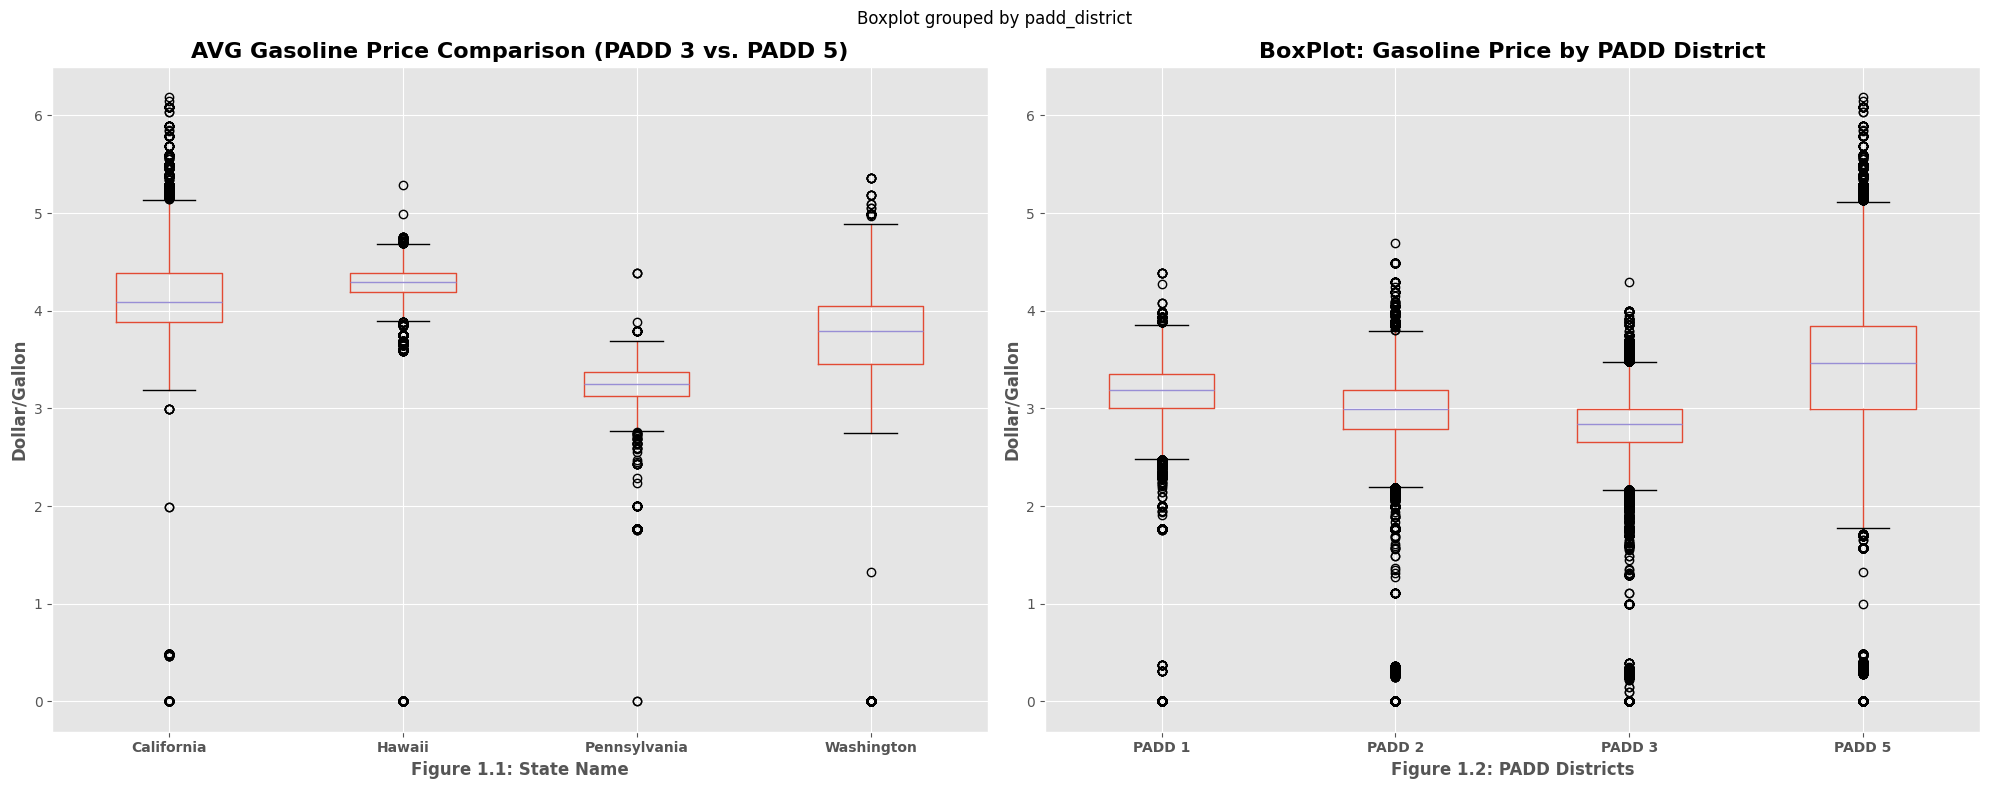

In [80]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1) 
pricing_comp_df.query("padd_district != 'N/A' ").sort_values(by='state_name').boxplot(column='price', by='state_name' ,  ax=ax)
ax.set_title("AVG Gasoline Price Comparison (PADD 3 vs. PADD 5)", fontweight='bold', fontsize=16) # TX having the lowest tax_rate
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels() , fontweight='bold' )
ax.set_xlabel("Figure 1.1: State Name", fontweight='bold')

ax = fig.add_subplot(1,2,2) 
padd_prices.boxplot(by='padd_district', column='price', ax=ax) # PADD 5 has the highest tax_rate (both state & federal) 
ax.set_title("BoxPlot: Gasoline Price by PADD District", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels() , fontweight='bold' )
ax.set_xlabel("Figure 1.2: PADD Districts", fontweight='bold')

plt.tight_layout() 

## **Daily, Weekly, and Monthly Average Gasoline Price Trends by PADD District** 

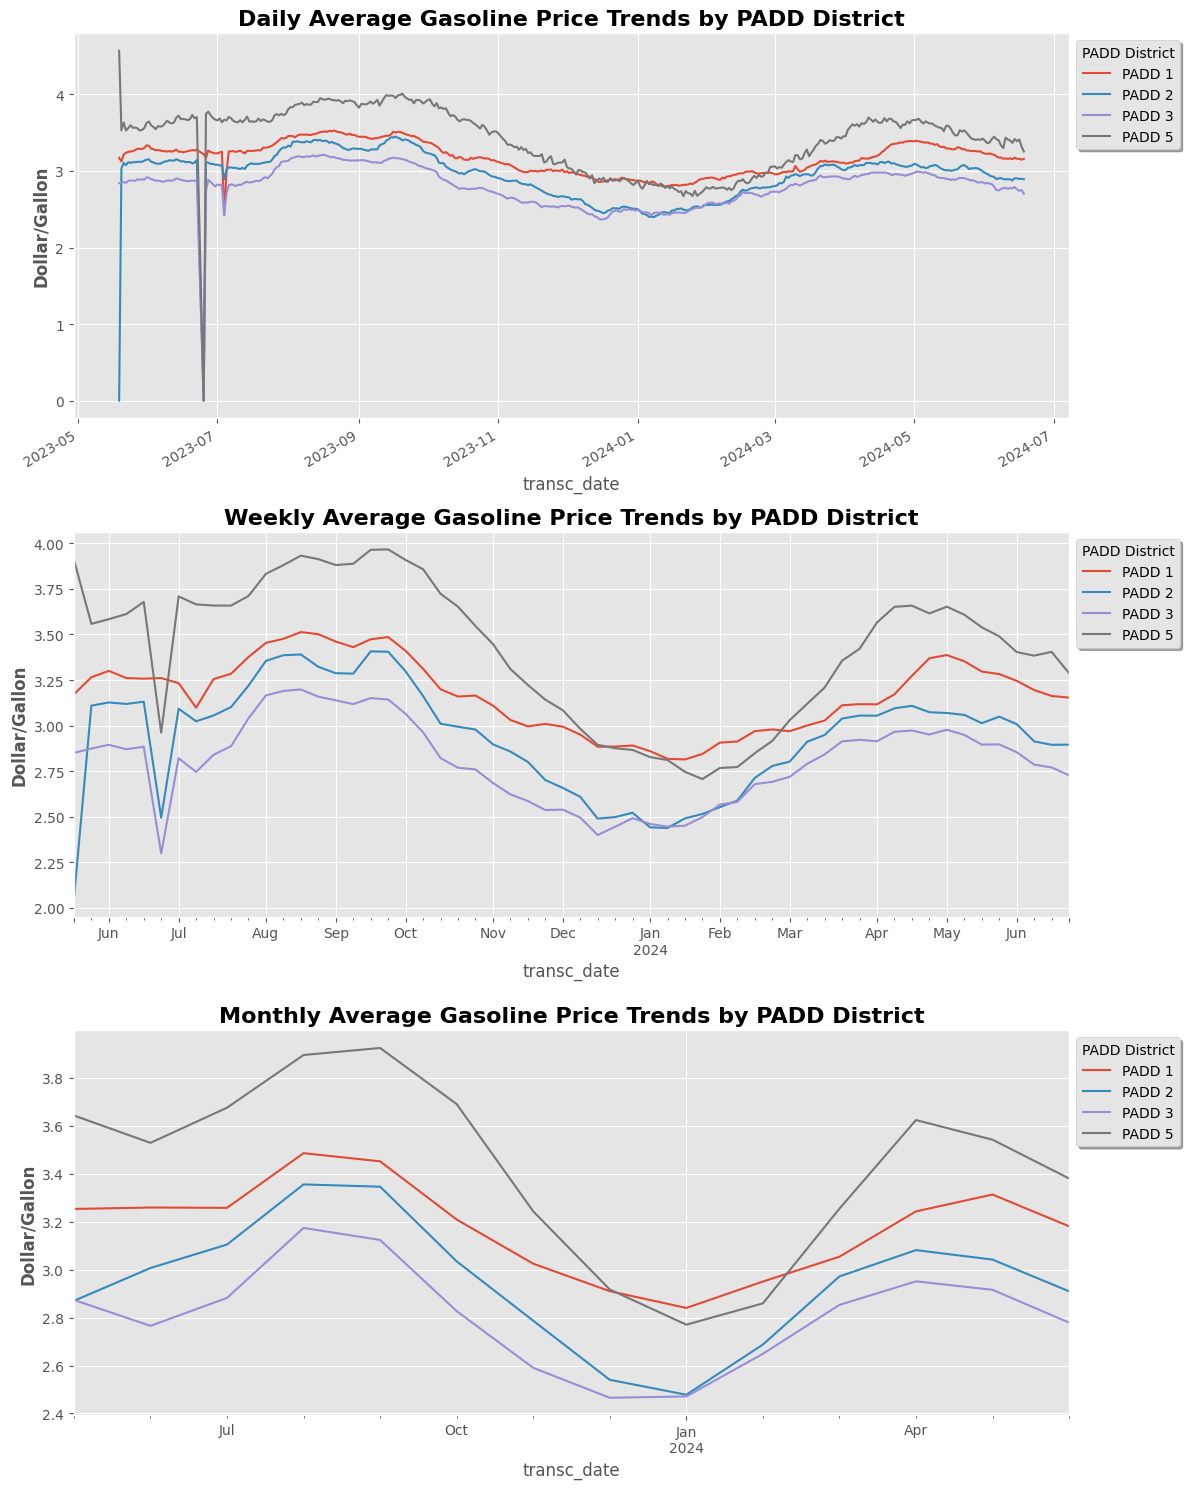

In [147]:
fig = plt.figure(figsize=(12,15))
ax = fig.add_subplot(3,1,1) 
padd_prices.groupby(['padd_district' , 'transc_date'])['price'].mean().unstack('padd_district').replace({np.nan:0.0}).plot(ax=ax) 
ax.set_title("Daily Average Gasoline Price Trends by PADD District", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.legend(title='PADD District', fancybox=True, shadow=True, bbox_to_anchor=(1,1))

ax = fig.add_subplot(3,1,2) 
padd_prices.groupby(['transc_date', 'padd_district'])['price'].mean().unstack('padd_district').replace({np.nan:0.0}).resample('W').mean().plot(ax=ax) 
ax.set_title("Weekly Average Gasoline Price Trends by PADD District", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.legend(title='PADD District', fancybox=True, shadow=True, bbox_to_anchor=(1,1))

ax = fig.add_subplot(3,1,3) 
padd_prices.groupby(['transc_date', 'padd_district'])['price'].mean().unstack('padd_district').replace({np.nan:0.0}).resample('M').mean().plot(ax=ax) 
ax.set_title("Monthly Average Gasoline Price Trends by PADD District", fontweight='bold', fontsize=16)
ax.set_ylabel("Dollar/Gallon", fontweight='bold')
ax.legend(title='PADD District', fancybox=True, shadow=True, bbox_to_anchor=(1,1))

plt.tight_layout() 